Setting up shop

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import re
import arviz as az

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

import functions as func

In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
az.style.use("arviz-darkgrid")

Loading data

In [4]:
df = pd.read_pickle("2023-10.pkl")
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

# train test split date
split_date = "2022-06-01"
X, y, X_test, y_test = func.train_test_split(df, split_date)

Difference non stationary variables

In [5]:
non_stationary_vars = func.get_non_stat_vars(df)
diff_df = df
diff_df[non_stationary_vars] = df[non_stationary_vars].diff()

non_stationary_vars_diff = func.get_non_stat_vars(diff_df)
diff_diff_df = diff_df
diff_diff_df[non_stationary_vars_diff] = diff_df[non_stationary_vars_diff].diff()

non_stationary_vars_diff_diff = func.get_non_stat_vars(diff_diff_df)
diff_diff_df = diff_diff_df.dropna()
X_diff, y_diff, X_diff_test, y_diff_test = func.train_test_split(diff_diff_df, split_date)

Getting linear correlations

In [6]:
correlation = diff_diff_df.corr()['inflation'].sort_values(ascending=False)
pearson_scores = correlation[1:26].sort_values(ascending=True)
linear_significant = pearson_scores[pearson_scores > 0.2].index.tolist()
linear_significant

['BAA', 'GS10', 'CUMFNS', 'AAA', 'BUSINVx', 'OILPRICEx', 'FEDFUNDS']

Estimate the hyperparameter $\lambda$ for the Bayesian LASSO

In [17]:
lm = LinearRegression()
lm.fit(X_diff,y_diff)

LinearRegression()

In [25]:
lambda_init = (X_diff.shape[1]*np.sqrt((np.sum((y_diff - lm.predict(X_diff))**2)) / (X_diff.shape[0] - X_diff.shape[1]))) / np.sum(np.abs(lm.coef_))
lambda_ = np.sqrt(2 * X_diff.shape[1] / sum(np.mean(func.gibbs_sampler_lambda(X_diff, y_diff, 500, lambda_init), axis=0)))

/Users/MorrisHeijke/Desktop/Uni/Master/Thesis Econometrics/thesis_code/functions.py:189: RuntimeWarning: covariance is not positive-semidefinite.
  beta.append(np.random.multivariate_normal(multi_norm_mean, multi_norm_cov))


In [26]:
lambda_list = [lambda_]
for i in range(1,120):
    lambda_ = np.sqrt(2 * X_diff.shape[1] / sum(np.mean(func.gibbs_sampler_lambda(X_diff, y_diff, 500, lambda_), axis=0)))
    lambda_list.append(lambda_)

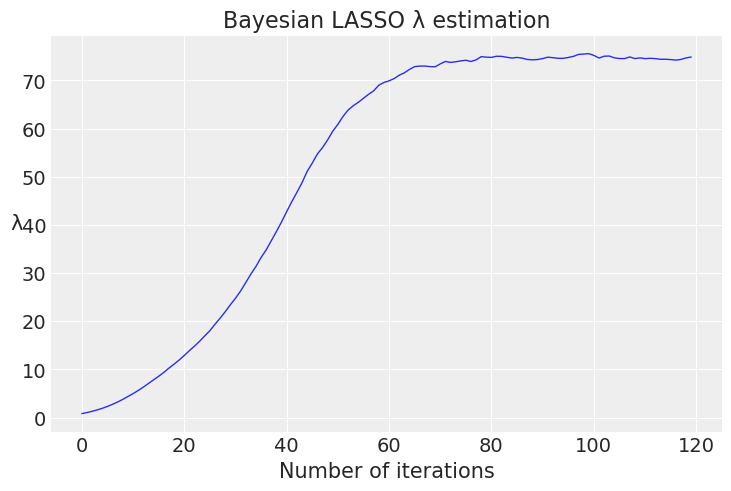

In [37]:
dict_df = {'iterations': range(0,120), 'λ':lambda_list}
df = pd.DataFrame(dict_df)

plt.plot('iterations', 'λ', data=df, linewidth=1)
plt.xlabel('Number of iterations')
plt.ylabel('λ',rotation=0)
plt.title('Bayesian LASSO λ estimation')
plt.savefig('Empirical_lambda.png')

In [28]:
lambda_

74.84484032974787

Get Random Forest hyperparameters

In [9]:
rf_regressor = RandomForestRegressor(random_state=0)

param_grid_rf = {'n_estimators': [10, 50, 100, 150, 200, 250, 300],
                'max_depth': [1,2,4,6]}

search_rf = GridSearchCV(rf_regressor, param_grid_rf, cv=5).fit(X_diff, y_diff)

print("The best RF hyperparameters are ",search_rf.best_params_)
rf_best_params = search_rf.best_params_

The best RF hyperparameters are  {'max_depth': 6, 'n_estimators': 150}


Get XGBoost hyperparameters

In [14]:
xgb_regressor = xgb.XGBRegressor(eval_metric='rmsle')

param_grid_xgb = {"max_depth":    [1, 2, 4, 6],
              "n_estimators": [10, 50, 100, 250, 500, 750],
              "learning_rate": [0.1],
              "gamma": [0.1, 1, 5, 10],
              "lambda": [0.1, 1, 5, 10]}

search_xgb = GridSearchCV(xgb_regressor, param_grid_xgb, cv=5).fit(X_diff, y_diff)

print("The best XGB hyperparameters are ",search_xgb.best_params_)
xgb_best_params = search_xgb.best_params_

The best XGB hyperparameters are  {'gamma': 1, 'lambda': 5, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 750}


Walk-Forward Validation

In [49]:
model_dict = dict()
model_dict['mean_model'] = func.mean_predictor()
model_dict['naive_model'] = func.naive_predictor()
model_dict['mlr_model'] = func.mlr_predictor()
model_dict['mlr_sig_model'] = func.mlr_predictor(linear_significant)
model_dict['lasso_model'] = func.lasso_predictor()
model_dict['bayes_lasso_model'] = func.bayes_lasso_predictor(lambda_)
model_dict['ridge_model'] = func.ridge_predictor()
model_dict['bayes_ridge_model'] = func.bayes_ridge_predictor()
model_dict['elnet_model'] = func.elasticnet_predictor()
model_dict['xgb_model'] = func.xgboost_predictor(xgb_best_params)
model_dict['rf_model'] = func.rf_predictor()
model_dict['arima_model'] = func.arima_predictor(y_diff, 2,0,1)
model_dict['var_model'] = func.VAR_predictor(["OILPRICEx","UNRATE", "FEDFUNDS"])

/Users/MorrisHeijke/Desktop/Uni/Master/Thesis Econometrics/thesis_code/.conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/MorrisHeijke/Desktop/Uni/Master/Thesis Econometrics/thesis_code/.conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/MorrisHeijke/Desktop/Uni/Master/Thesis Econometrics/thesis_code/.conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [50]:
results = func.ts_cross_validation(model_dict, X_diff, y_diff, 6, 12)
result_frame = pd.DataFrame({
                        'mean': results['mean_model'],
                        'naive': results['naive_model'],
                        'mlr': results['mlr_model'],
                        'mlr sig': results['mlr_sig_model'],
                        'lasso': results['lasso_model'],
                        'bayes lasso': results['bayes_lasso_model'],
                        'ridge': results['ridge_model'],
                        'bayes ridge': results['bayes_ridge_model'],
                        'elnet': results['elnet_model'],
                        'xgb': results['xgb_model'],
                        'rf': results['rf_model'],
                        'arima': results['arima_model'],
                        'var': results['var_model']
                        }, index=['MSE Train', 'MSE Validation', 'MAE Train', 'MAE Validation', 'R2 Train', 'R2 Validation'])

round(result_frame.T, 3)

/Users/MorrisHeijke/Desktop/Uni/Master/Thesis Econometrics/thesis_code/.conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.680e+00, tolerance: 9.809e-01
  model = cd_fast.enet_coordinate_descent(
/Users/MorrisHeijke/Desktop/Uni/Master/Thesis Econometrics/thesis_code/.conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.100e+01, tolerance: 9.809e-01
  model = cd_fast.enet_coordinate_descent(
/Users/MorrisHeijke/Desktop/Uni/Master/Thesis Econometrics/thesis_code/.conda/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stat

,MSE Train,MSE Validation,MAE Train,MAE Validation,R2 Train,R2 Validation
mean,14.200,11.680,2.664,2.629,0.000,-1.104
naive,0.000,15.523,0.000,3.057,1.000,-2.071
mlr,1.528,63.945,0.947,4.376,0.892,-8.810
mlr sig,7.786,8.225,2.096,2.042,0.452,-0.353
lasso,2.479,83.756,1.180,4.631,0.825,-11.498
bayes lasso,2.552,89.934,1.241,5.516,0.820,-12.829
ridge,1.553,66.446,0.955,4.591,0.890,-9.150
bayes ridge,1.939,87.557,1.057,5.068,0.863,-12.438
elnet,2.271,92.344,1.133,5.060,0.840,-12.952
xgb,0.072,6.502,0.207,1.744,0.995,-0.169


Out-of-sample forecast

In [51]:
out_of_sample_results, y_pred_dict = func.out_of_sample_forecast(model_dict, diff_diff_df, split_date)
out_of_sample_result_frame = pd.DataFrame({
                        'mean': out_of_sample_results['mean_model'],
                        'naive': out_of_sample_results['naive_model'],
                        'mlr': out_of_sample_results['mlr_model'],
                        'mlr sig': out_of_sample_results['mlr_sig_model'],
                        'lasso': out_of_sample_results['lasso_model'],
                        'bayes lasso': out_of_sample_results['bayes_lasso_model'],
                        'ridge': out_of_sample_results['ridge_model'],
                        'bayes ridge': out_of_sample_results['bayes_ridge_model'],
                        'elnet': out_of_sample_results['elnet_model'],
                        'xgb': out_of_sample_results['xgb_model'],
                        'rf': out_of_sample_results['rf_model'],
                        'arima': out_of_sample_results['arima_model'],
                        'var': out_of_sample_results['var_model']
                        }, index=['MSE', 'MAE', 'R2'])

round(out_of_sample_result_frame.T, 3)

/Users/MorrisHeijke/Desktop/Uni/Master/Thesis Econometrics/thesis_code/.conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.093e+02, tolerance: 1.064e+00
  model = cd_fast.enet_coordinate_descent(
/Users/MorrisHeijke/Desktop/Uni/Master/Thesis Econometrics/thesis_code/.conda/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.022e+03, tolerance: 1.064e+00
  model = cd_fast.enet_coordinate_descent(
/Users/MorrisHeijke/Desktop/Uni/Master/Thesis Econometrics/thesis_code/.conda/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stat

,MSE,MAE,R2
mean,12.561,2.536,-0.003
naive,44.321,5.453,-2.538
mlr,13.138,2.517,-0.049
mlr sig,7.407,1.924,0.409
lasso,6.129,2.028,0.511
bayes lasso,9.416,2.490,0.248
ridge,10.797,2.323,0.138
bayes ridge,7.012,2.001,0.440
elnet,6.479,2.096,0.483
xgb,5.236,1.718,0.582
